In [ ]:
'''
This script runs a simple LSTM model on a single columns (XLocation or YLocation)
and predict k time steps in the future (t+1, t+2...t+k)

'''


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pickle import dump, load
import sys
import keras
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from keras.models import load_model


Using TensorFlow backend.


In [2]:
def plot_prediction(x, y_true, y_pred):
    """Plots the predictions.

    Arguments
    ---------
    x: Input sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_true: True output sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_pred: Predicted output sequence (input_sequence_length,
        dimension_of_signal)
    """
    label1 = "Seen (past) values"
    label2 = "True future values"
    label3 = "Predictions"
    
    plt.figure(figsize=(12, 3))
    plt.plot(range(len(x)),x, "o--b", label=label1)
    plt.plot(range(len(x), len(x) + len(y_true) ), y_true, "x--b", label=label2)
    plt.plot(range(len(x), len(x) + len(y_pred)),y_pred, "o--y", label=label3)
    
    plt.legend(loc='best')
    plt.title("Predictions v.s. true values")
    plt.show()
    
    


In [3]:
def size_per_targets(data):
    #print("Total: ", data.shape[0])
    sizes = data.groupby(['id', 'file_id']).size()
    #print(sizes)
    #print(type(sizes))
    #print("Total:",sum(list(sizes)))

    return list(sizes)


In [4]:
def generate_input_data(data, sizes, train_len, target_seq):
    targets = len(sizes)
    start = 0
    sequences = []
    X = []
    y = []
    
    for i, size in enumerate(sizes):
        print("Chunk", i+1)
        end = start + size
        print("Size of block %d, Range: %d-%d" % (size, start, end))
        temp_df = data.iloc[start:end]
        
        values = temp_df.iloc[:,-target_seq].values
        for i in range(train_len, len(values)):
            seq = values[i-train_len:i]
            
            sequences.append(seq)
                   
        # update start
        start = start + size
    
    sequences = np.array(sequences)    
    print("[INFO] Sequences generated:", len(sequences))
    
    X = sequences[:,:-target_seq]
    y = sequences[:,-target_seq]

    return X, y



# MAIN   


## Load the data

In [42]:
filename = 'data/AllData.csv'
data = pd.read_csv(filename)
print(data.shape)
print(list(data.columns))


(500050, 18)
['id', 'file_id', 'Pn', 'Pe', 'h', 'Va', 'Phi', 'Theta', 'Chi', 'Psi', 'Vg', 'Azimuth', 'Elevation', 'XPixel', 'YPixel', 'ZValue', 'XLocation', 'YLocation']


## Generate the input data


#### Defining Parameters


In [89]:
column_of_interest = 'XLocation'
input_seq = 10
target_seq = 1      # 
predict_k = 3       # predict k time steps in the future
train_len = input_seq + target_seq
target = 0     # 0 = AllTargets
test_percentage = 0.2
rand_test = True

dropout = .4
batch_size = 64
neurons = 64
epochs = 100

model_filename = 'models/model_lstm_'+column_of_interest+"_"+str(input_seq)+"_timesteps_dropout.h5"
scaler_filename = 'models/model_lstm_'+column_of_interest+"_"+str(input_seq)+"_timesteps_dropout"


## Generate input data


In [90]:
# -1 is All data, else is the target id

if target != 0:
    input_data = data[data['id'] == target]
else:
    input_data = data

# Take only the column of interest
input_data = input_data[['id', 'file_id', column_of_interest]]
columns = input_data.columns

# We need to generate the sequences based on the id and file_id
sizes = size_per_targets(input_data)
X, y = generate_input_data(input_data, sizes, train_len, target_seq)


Chunk 1
Size of block 10001, Range: 0-10001
Chunk 2
Size of block 10001, Range: 10001-20002
Chunk 3
Size of block 10001, Range: 20002-30003
Chunk 4
Size of block 10001, Range: 30003-40004
Chunk 5
Size of block 10001, Range: 40004-50005
Chunk 6
Size of block 10001, Range: 50005-60006
Chunk 7
Size of block 10001, Range: 60006-70007
Chunk 8
Size of block 10001, Range: 70007-80008
Chunk 9
Size of block 10001, Range: 80008-90009
Chunk 10
Size of block 10001, Range: 90009-100010
Chunk 11
Size of block 10001, Range: 100010-110011
Chunk 12
Size of block 10001, Range: 110011-120012
Chunk 13
Size of block 10001, Range: 120012-130013
Chunk 14
Size of block 10001, Range: 130013-140014
Chunk 15
Size of block 10001, Range: 140014-150015
Chunk 16
Size of block 10001, Range: 150015-160016
Chunk 17
Size of block 10001, Range: 160016-170017
Chunk 18
Size of block 10001, Range: 170017-180018
Chunk 19
Size of block 10001, Range: 180018-190019
Chunk 20
Size of block 10001, Range: 190019-200020
Chunk 21
Siz

### Getting train, test data

In [91]:

# If we select the train and test randomly
if rand_test:
    print("Randomly picking train, test dataset")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percentage, 
                                                        shuffle=False, random_state=42)
# Else, select the last % part as testing
else:
    print("Train, test split based on percentage")
    test_size = int(X.shape[0] * test_percentage)
    train_size = int(X.shape[0] - test_size)
    print("Train size:", train_size)
    X_train = X[:train_size, :]
    X_test = X[train_size:, :]
    
    y_train = y[:train_size]
    y_test = y[train_size:]    

print("X Train size=", X_train.shape[0])
print("X Test size=",X_test.shape[0])
print("y Train size=", y_train.shape[0])
print("y Test size=",y_test.shape[0])


Randomly picking train, test dataset
X Train size= 249750
X Test size= 249750
y Train size= 249750
y Test size= 249750


### Scale the Input Data


In [92]:
# fit the values between 0 and 1
scaler_object = MinMaxScaler()

scaler_object.fit(X_train)

scaled_X_train =  scaler_object.transform(X_train)
scaled_X_test =  scaler_object.transform(X_test)

train_X = scaled_X_train.reshape((scaled_X_train.shape[0], 1, scaled_X_train.shape[1]))
test_X = scaled_X_test.reshape((scaled_X_test.shape[0], 1, scaled_X_test.shape[1]))


#print(train_X.shape, y_train.shape, test_X.shape, y_test.shape)

train_X = train_X.reshape((scaled_X_train.shape[0], scaled_X_train.shape[1], 1))

test_X = test_X.reshape((scaled_X_test.shape[0], scaled_X_test.shape[1], 1))
print("(Instances,Sequence,Features)")
print(train_X.shape, y_train.shape, test_X.shape, y_test.shape)



(Instances,Sequence,Features)
(249750, 10, 1) (249750,) (249750, 10, 1) (249750,)


## Create the LSTM model


In [93]:
### If it is already saved then do not run it again, it takes time
# design network
model = Sequential()
model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(dropout))
model.add(LSTM(neurons))
model.add(Dropout(dropout))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()
# fit network
history = model.fit(train_X, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(test_X, y_test), verbose=2, shuffle=False)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 10, 64)            16896     
_________________________________________________________________
dropout_11 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Train on 249750 samples, validate on 249750 samples
Epoch 1/100
 - 41s - loss: 123.3119 - val_loss: 97.0820
Epoch 2/100
 - 38s - loss: 65.

### Plot the loss

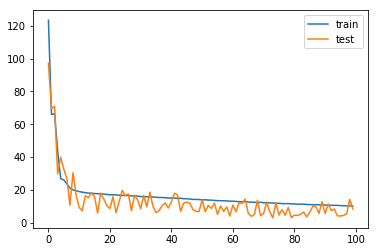

dict_keys(['val_loss', 'loss'])


In [94]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

print(history.history.keys())


### Save the model and scaler


In [95]:
print(model_filename)
model.save(model_filename)
print(scaler_filename)
dump(scaler_object, open(scaler_filename, 'wb'))


models/model_lstm_XLocation_10_timesteps_dropout.h5
models/model_lstm_XLocation_10_timesteps_dropout


### Load the model


In [96]:
model = load_model(model_filename)
scaler_object = load(open(scaler_filename, 'rb'))


## Evaluate the model


In [97]:
# make a prediction
print("test_X shape", test_X.shape)
yhat = model.predict(test_X)
# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, yhat))
print('Test RMSE: %.3f' % rmse)
mae = np.sqrt(mean_absolute_error(y_test, yhat))
print('Test MAE: %.3f' % mae)


test_X shape (249750, 10, 1)
Test RMSE: 10.728
Test MAE: 2.898


## Comparing results

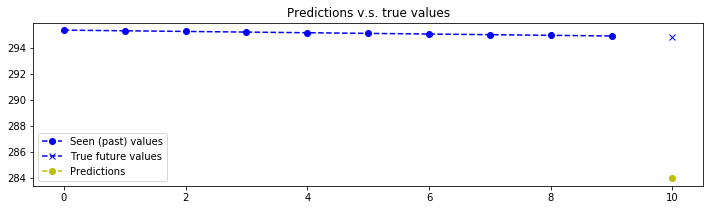

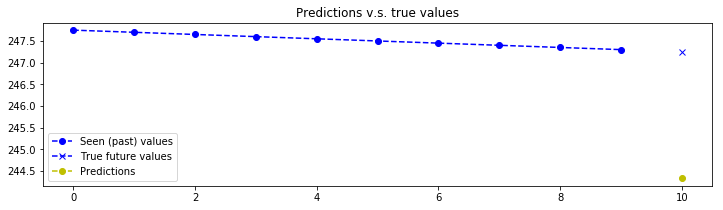

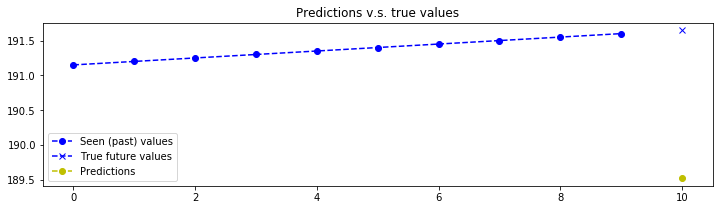

In [106]:
# Picked k random test instances
#t_X = test_X.reshape(test_X.shape[0], test_X.shape[1])
t_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])

indices = np.random.choice(range(t_X.shape[0]), replace=False, size=3)
for index in indices:
    x_test = test_X[index]
    x_test = x_test.reshape(x_test.shape[1], x_test.shape[0])
    test_X_rescaled = scaler_object.inverse_transform(x_test)
    plot_prediction(test_X_rescaled[0], [y_test[index]], yhat[index])



## Predicting k steps in the future


In [107]:
all_predictions = []
for index in indices:
    print("~"*50)
    print("~"*50)
    print("Predictions for index:", index)
    x_test = np.asarray([test_X[index]])    

    input = x_test
    print("input shape", input.shape)
    predictions = []
    
    for i in range(predict_k):
        print("Pred ", i+1)    
        print("Input shape:", input.shape)
        window = input.reshape(x_test.shape[0], x_test.shape[1])
        ##print("Window")
        ##print(window)
        ##print("window shape",window.shape)
        
        # This will convert the values to Location values
        window_rescaled = scaler_object.inverse_transform(window)
        print("Window rescaled")
        print(window_rescaled)
        ##print("window rescaled shape:",window_rescaled.shape)
        
        yhat = model.predict(input)
        predictions.append(yhat[0][0])    
        print('yhat', yhat)
        ##print(type(yhat))
        ##print(type(window_rescaled))
        
        input = np.append(window_rescaled[:,1:], yhat)
        print("New window:", input)
        ##print("New window shape", input.shape)
        input = input.reshape(1, input.shape[0], window.shape[0])
        ##print("New new input shape:", input.shape)
        ##print(input)
        # This will convert the location values to scaled values
        
        input = input.reshape(1, input.shape[1])
        input = scaler_object.transform(input)
        ##print("New scaled input")
        ##print(input)
        ##print("New scaled input shape", input.shape)
        
        input = input.reshape(1, input.shape[1], window.shape[0])
        ##print("input shape",input.shape)
        print("#" * 50)
    
    print(predictions)
    all_predictions.append(predictions)
print(all_predictions)
        

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Predictions for index: 6099
input shape (1, 10, 1)
Pred  1
Input shape: (1, 10, 1)
Window rescaled
[[295.35 295.3  295.25 295.2  295.15 295.1  295.05 295.   294.95 294.9 ]]
yhat [[283.93503]]
New window: [295.3        295.25       295.2        295.15       295.1
 295.05       295.         294.95       294.9        283.93502808]
##################################################
Pred  2
Input shape: (1, 10, 1)
Window rescaled
[[295.3        295.25       295.2        295.15       295.1
  295.05       295.         294.95       294.9        283.93502808]]
yhat [[283.57306]]
New window: [295.25       295.2        295.15       295.1        295.05
 295.         294.95       294.9        283.93502808 283.57305908]
##################################################
Pred  3
Input shape: (1, 10, 1)
Window rescaled
[[295.25       295.2        295.15       295.1        295.05
  295.         294.95 

## Plot future predictions


Initial X: [295.35 295.3  295.25 295.2  295.15 295.1  295.05 295.   294.95 294.9 ]
True t+1: [294.85]
k predictions [283.93503, 283.57306, 283.71417]
Initial X: [247.75 247.7  247.65 247.6  247.55 247.5  247.45 247.4  247.35 247.3 ]
True t+1: [247.25]
k predictions [244.32819, 244.18501, 244.15302]
Initial X: [191.15 191.2  191.25 191.3  191.35 191.4  191.45 191.5  191.55 191.6 ]
True t+1: [191.65]
k predictions [189.51857, 189.47119, 189.52872]


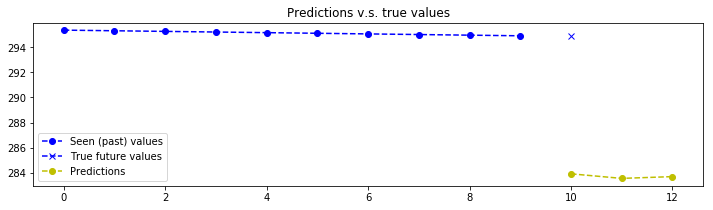

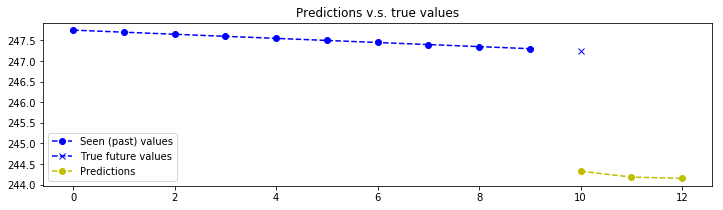

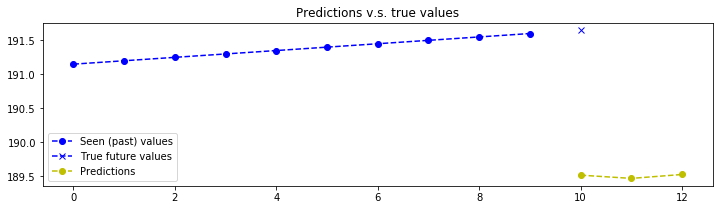

In [108]:
for i,index in enumerate(indices):
    x_test = test_X[index]
    x_test = x_test.reshape(x_test.shape[1], x_test.shape[0])
    test_X_rescaled = scaler_object.inverse_transform(x_test)
    #plot_prediction
    print("Initial X:",test_X_rescaled[0])
    print("True t+1:",[y_test[index]])
    print("k predictions",all_predictions[i])
    plot_prediction(test_X_rescaled[0], [y_test[index]], all_predictions[i])
